# Section 1: Import necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Section 2: Loading the computed smoke estimate data

This is done to merge it with the AQI dataframe later.

In [2]:
smoke_est_df = pd.read_csv('/Users/aviva/Desktop/MSDS/quarter_4/Human Centered Data Science/Part 1/GeoJSON Exports/intermediate_data/smoke_est.csv')

In [3]:
smoke_est_df.head()

,FireYear,GISAcres,shortest_dist,Smoke_Estimate
0,1963,766.773922,896.624518,0.022618
1,1964,1146.301446,870.262828,0.153983
2,1965,587.560328,992.533750,0.149189
3,1966,1397.433572,932.505220,0.111709
4,1967,1175.659287,1010.487956,0.098337


A fun lil plot

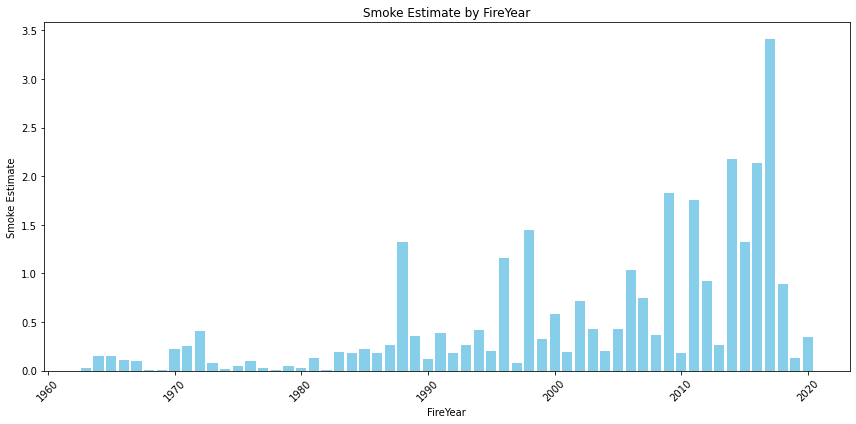

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(smoke_est_df['FireYear'], smoke_est_df['Smoke_Estimate'], color='skyblue')
plt.xlabel('FireYear')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate by FireYear')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Professor David has provided [sample code](https://drive.google.com/file/d/1bxl9qrb_52RocKNGfbZ5znHVqFDMkUzf/view) for accessing the US EPA Air Quality System API. This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license. Revision 1.1 - September 5, 2023

## Section 3: Pulling US EPA Air Quality System API

In [5]:
import pandas as pd
import json, time
import requests

In [7]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

Uncomment this to sign up and get your username and APIKEY.

In [8]:

# #
# #    This implements the sign-up request. The parameters are standardized so that this function definition matches
# #    all of the others. However, the easiest way to call this is to simply call this function with your preferred
# #    email address.
# #
# def request_signup(email_address = None,
#                    endpoint_url = API_REQUEST_URL, 
#                    endpoint_action = API_ACTION_SIGNUP, 
#                    request_template = AQS_REQUEST_TEMPLATE,
#                    headers = None):
    
#     # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
#     if email_address:
#         request_template['email'] = email_address        
#     if not request_template['email']: 
#         raise Exception("Must supply an email address to call 'request_signup()'")
    
#     # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
#     request_url = endpoint_url+endpoint_action.format(**request_template)
        
#     # make the request
#     try:
#         # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
#         # during the request processing - throttling is always a good practice with a free data source
#         if API_THROTTLE_WAIT > 0.0:
#             time.sleep(API_THROTTLE_WAIT)
#         response = requests.get(request_url, headers=headers)
#         json_response = response.json()
#     except Exception as e:
#         print(e)
#         json_response = None
#     return json_response

# #
# #    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
# #    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
# #
# print("Requesting SIGNUP ...")
# response = request_signup("avivam@uw.edu")
# print(json.dumps(response,indent=4))
# #

Getting information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. 

In [9]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [10]:
USERNAME = 'avivam@uw.edu'
APIKEY = 'taupewolf98'

In [11]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

Trying to get a list of specific sensors called AQI POLLUTANTS. The resultant response contains a set of sensor ID numbers and the sensor numbers as well as a description or name for each sensor.

In [12]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [13]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


Breaking the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [14]:
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

Specifying Salina city location 

In [15]:
CITY_LOCATIONS = {
    'salina' :       {'city'   : 'Salina',
                       'county' : 'Saline',
                       'state'  : 'Kansas',
                       'fips'   : '20169',
                       'latlon' : [38.8403, -97.6114] }, 
}

Finding which monitoring systems are nearby.

In [16]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['salina']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['salina']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": "Salina lead"
    }
]


Extracting values and restructuring the response to make it a little more usable.

In [17]:
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [18]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['salina']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['salina']['fips'][2:]

# request daily summary data for the month of July in 2021
gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="20190701", end_date="20190731")
print("Response for the gaseous pollutants ...")
#
if gaseous_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(gaseous_aqi['Data'],indent=4))
elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(gaseous_aqi,indent=4))

request_data['param'] = AQI_PARAMS_PARTICULATES
# request daily summary data for the month of July in 2021
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20190701", end_date="20190731")
print("Response for the particulate pollutants ...")
#
if particulate_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(particulate_aqi['Data'],indent=4))
elif particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(particulate_aqi,indent=4))


Response for the gaseous pollutants ...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants ...
Looks like the response generated no data. You might take a closer look at your request and the response data.


In [20]:
# DONT RUN THIS
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result

In [21]:
extract_gaseous = extract_summary_from_response(gaseous_aqi)
print("Summary of gaseous extraction ...")
print(json.dumps(extract_gaseous,indent=4))

extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))


Summary of gaseous extraction ...
{}
Summary of particulate extraction ...
{}


Since no data was returned for this, we will now be using the Bounding Box Approach.

In [22]:
LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
#
#   Compute a rough estimates for a bounding box around a given place
#   The bounding box is scaled in 50 mile increments. That is the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#
def bounding_latlon(place=None,scale=1.0):
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

In [23]:
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_MONITORS_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [24]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES     # remember we have both gaseous and particulates
# 
#   We got the monitoring stations for Bend OR above (Deschutes county) - let's work with that one again
request_data['state'] = CITY_LOCATIONS['salina']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['salina']['fips'][2:]
#
# the first example uses the default - request monitors by county, we'll just use a recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731")
#
# the response should be similar to the 'list' request above - but in this case we should only get monitors that
# monitor the AQI_PARAMS_PARTICULATES set of params.
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

{
    "Header": [
        {
            "status": "No data matched your selection",
            "request_time": "2023-11-06T03:53:34-05:00",
            "url": "https://aqs.epa.gov/data/api/monitors/byCounty?email=avivam@uw.edu&key=taupewolf98&param=81102,88101,88502&bdate=20210701&edate=20210731&state=20&county=169",
            "rows": 0
        }
    ],
    "Data": []
}


No luck here, too. So, we will now need to collect monthly AQI estimates using the `calculate_monthly_aqi_estimate` function. This estimates the monthly Air Quality Index for Salina by making an API request for daily air quality data within a specified date range. It then calculates the average AQI values for specific particulate pollutants, computes the estimated average AQI for particulate matter, and returns the largest monthly AQI estimate found during the given period.

In [39]:
def calculate_monthly_aqi_estimate(start_date, end_date):
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    
    bbox = bounding_latlon(CITY_LOCATIONS['salina'], scale=10.0)
    request_data['minlat'], request_data['maxlat'], request_data['minlon'], request_data['maxlon'] = bbox
    
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=end_date, endpoint_action=API_ACTION_DAILY_SUMMARY_BOX)
    
    if particulate_aqi is None:
        print("No data received for the specified date range.")
        return None
    
    extract_particulate = extract_summary_from_response(particulate_aqi)
    largest_aqi_monthly_estimate = 0
    
    for station_data in extract_particulate.values():
        avg_81102_aqi, avg_88101_aqi = 0, 0
        
        for pollutant_code, pollutant_data in station_data.get("pollutant_type", {}).items():
            counter = 0
            for day_data in pollutant_data.get("data", {}).values():
                for data_point in day_data:
                    if data_point.get("sample_duration") == "24-HR BLK AVG":
                        aqi = data_point.get('aqi')
                        if pollutant_code == "81102":
                            avg_81102_aqi += aqi
                        if pollutant_code == "88101":
                            avg_88101_aqi += aqi
                        counter += 1
            if counter > 0:
                avg_81102_aqi /= counter
                avg_88101_aqi /= counter
        
        estimated_avg_pp = (avg_81102_aqi + avg_88101_aqi) / 2
        largest_aqi_monthly_estimate = max(largest_aqi_monthly_estimate, estimated_avg_pp)
    
    return largest_aqi_monthly_estimate

# trying it out for a certain month
aqi_est = get_AQI_estimate_for_month('20020601', '20020701')
print("AQI estimate:", aqi_est)

AQI estimate: 20.410714285714285


Now we loop through the years 1963 to 2022, and for each and month, we determine the last date of that month (taking leap years into account). Then we call the calculate_monthly_aqi_estimate function to estimate the monthly AQI and then finally store it in the monthly_aqi dictionary

In [40]:
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

In [41]:
monthly_aqi = {}
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

This takes 20 mins to run

In [42]:
for year in range(1963, 2023):
    for month in months:
        if month == "02":
            end_day = "29" if is_leap_year(year) else "28"
        elif month in ["04", "06", "09", "11"]:
            end_day = "30"
        else:
            end_day = "31"
        begin = str(year) + month + "01"
        end = str(year) + month + end_day
        monthly_aqi[begin] = calculate_monthly_aqi_estimate(begin, end)

In [43]:
monthly_aqi

{'19630101': 0,
 '19630201': 0,
 '19630301': 0,
 '19630401': 0,
 '19630501': 0,
 '19630601': 0,
 '19630701': 0,
 '19630801': 0,
 '19630901': 0,
 '19631001': 0,
 '19631101': 0,
 '19631201': 0,
 '19640101': 0,
 '19640201': 0,
 '19640301': 0,
 '19640401': 0,
 '19640501': 0,
 '19640601': 0,
 '19640701': 0,
 '19640801': 0,
 '19640901': 0,
 '19641001': 0,
 '19641101': 0,
 '19641201': 0,
 '19650101': 0,
 '19650201': 0,
 '19650301': 0,
 '19650401': 0,
 '19650501': 0,
 '19650601': 0,
 '19650701': 0,
 '19650801': 0,
 '19650901': 0,
 '19651001': 0,
 '19651101': 0,
 '19651201': 0,
 '19660101': 0,
 '19660201': 0,
 '19660301': 0,
 '19660401': 0,
 '19660501': 0,
 '19660601': 0,
 '19660701': 0,
 '19660801': 0,
 '19660901': 0,
 '19661001': 0,
 '19661101': 0,
 '19661201': 0,
 '19670101': 0,
 '19670201': 0,
 '19670301': 0,
 '19670401': 0,
 '19670501': 0,
 '19670601': 0,
 '19670701': 0,
 '19670801': 0,
 '19670901': 0,
 '19671001': 0,
 '19671101': 0,
 '19671201': 0,
 '19680101': 0,
 '19680201': 0,
 '196803

# Section 4: Saving data to a pandas dataframe

In [46]:
import csv

In [47]:
csv_file_path = "/Users/aviva/Desktop/MSDS/quarter_4/Human Centered Data Science/Part 1/GeoJSON Exports/intermediate_data/monthly_aqi.csv"  

csv_data = [["Year", "Month", "AQI"]]
for key, value in monthly_aqi.items():
    Year = key[:4]
    Month = key[4:6]
    AQI = value
    csv_data.append([Year, Month, AQI])

with open(csv_file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(csv_data)

print(f"file saved in {csv_file_path}")

file saved in /Users/aviva/Desktop/MSDS/quarter_4/Human Centered Data Science/Part 1/GeoJSON Exports/intermediate_data/monthly_aqi.csv


# Section 5: Misc Analysis

In [6]:
monthly_aqi_df = pd.read_csv('/Users/aviva/Desktop/MSDS/quarter_4/Human Centered Data Science/Part 1/GeoJSON Exports/intermediate_data/monthly_aqi.csv')

In [7]:
monthly_aqi_df

,Year,Month,AQI
0,1963,1,0.000000
1,1963,2,0.000000
2,1963,3,0.000000
3,1963,4,0.000000
4,1963,5,0.000000
...,...,...,...
715,2022,8,23.231530
716,2022,9,24.416667
717,2022,10,23.532258
718,2022,11,22.083333


In [8]:
monthly_aqi_df.describe()

,Year,Month,AQI
count,720.000000,720.000000,720.000000
mean,1992.500000,6.500000,8.741151
std,17.330141,3.454452,10.694894
min,1963.000000,1.000000,0.000000
25%,1977.750000,3.750000,0.000000
50%,1992.500000,6.500000,0.000000
75%,2007.250000,9.250000,18.796042
max,2022.000000,12.000000,39.226500


<AxesSubplot:>

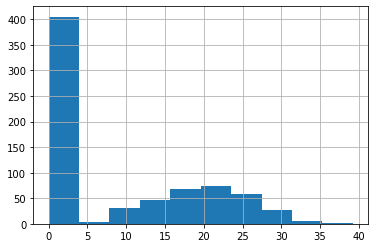

In [9]:
monthly_aqi_df['AQI'].hist()

<AxesSubplot:>

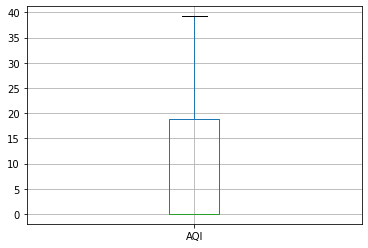

In [10]:
monthly_aqi_df.boxplot('AQI')

# Section 6: Imputing missing AQI Values

We now impute AQI values, calculate yearly averages, and prepare our dataset for further predicitive analysis. In order to do this, we will use Non-Negative Least Squares (nnls) to find coefficients for prediction.

In [11]:
import pandas as pd
from scipy.optimize import nnls

In a nutshell - firstly missing or zero AQI values are identified in the dataset, then predicted AQI values are calculated and adjusted to be non-negative and finally, the missing AQI values are replaced with the predicted values.

In [12]:
X = monthly_aqi_df[['Year', 'Month']]
Y = monthly_aqi_df['AQI']
imputed_aqi_df = monthly_aqi_df.copy()
coefficients, _ = nnls(X.values, Y.values)
rows_to_impute = imputed_aqi_df['AQI'] == 0
predicted_aqi = X.values.dot(coefficients)
predicted_aqi[predicted_aqi < 0] = 0
imputed_aqi_df.loc[rows_to_impute, 'AQI'] = predicted_aqi[rows_to_impute]

In [13]:
imputed_aqi_df.head()

,Year,Month,AQI
0,1963,1,8.690167
1,1963,2,8.690167
2,1963,3,8.690167
3,1963,4,8.690167
4,1963,5,8.690167


Yearly average AQI values are computed from the imputed data.

In [20]:
yearly_imputed = imputed_aqi_df.groupby('Year')['AQI'].mean().reset_index()

In [21]:
yearly_imputed.head()

,Year,AQI
0,1963,8.690167
1,1964,8.694594
2,1965,8.699021
3,1966,8.703448
4,1967,8.707875


In [22]:
smoke_est_df.head()

,FireYear,GISAcres,shortest_dist,Smoke_Estimate
0,1963,766.773922,896.624518,0.022618
1,1964,1146.301446,870.262828,0.153983
2,1965,587.560328,992.533750,0.149189
3,1966,1397.433572,932.505220,0.111709
4,1967,1175.659287,1010.487956,0.098337


# Section 7: Preparing final dataset used for predictive analysis

We now merge the AQI data with the smoke estimate data which was imported earlier.

In [23]:
pred_df_1 = smoke_est_df.merge(yearly_imputed, left_on='FireYear', right_on='Year', how='inner')
pred_df_1 = pred_df_1.drop(columns='FireYear')

In [24]:
pred_df_1.head()

,GISAcres,shortest_dist,Smoke_Estimate,Year,AQI
0,766.773922,896.624518,0.022618,1963,8.690167
1,1146.301446,870.262828,0.153983,1964,8.694594
2,587.560328,992.533750,0.149189,1965,8.699021
3,1397.433572,932.505220,0.111709,1966,8.703448
4,1175.659287,1010.487956,0.098337,1967,8.707875


In [25]:
pred_df_1.to_csv('/Users/aviva/Desktop/MSDS/quarter_4/Human Centered Data Science/Part 1/GeoJSON Exports/intermediate_data/pred_df.csv', index=False)